<a href="https://colab.research.google.com/github/mlaugharn/math178project/blob/master/brain_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [2]:
!pip install medpy simpleitk

     |████████████████████████████████| 153kB 2.6MB/s 
     |████████████████████████████████| 42.5MB 72kB/s 
  Created wheel for medpy: filename=MedPy-0.4.0-cp36-cp36m-linux_x86_64.whl size=753433 sha256=fc8e16fde8aa172185cec82b7d3aac719d13ea8d0818ffaacbc8bed8c1bd9d99
  Stored in directory: /root/.cache/pip/wheels/8c/c9/9c/2c6281c7a72b9fb1570862a4f028af7ce38405008354fbf870
Successfully built medpy


In [2]:
!pwd

/content


In [3]:
!ls

gdrive	sample_data


In [4]:
!wget http://cupid.whatbox.ca:8000/brats2015.zip
!unzip brats2015.zip -d './brats 2015'
!pwd 

--2020-05-28 23:27:55--  http://cupid.whatbox.ca:8000/brats2015.zip
Resolving cupid.whatbox.ca (cupid.whatbox.ca)... 192.131.44.65, 2620:b8:4000:1001::1:1
Connecting to cupid.whatbox.ca (cupid.whatbox.ca)|192.131.44.65|:8000... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3115267301 (2.9G) [application/zip]
Saving to: ‘brats2015.zip’

brats2015.zip       100%[===================>]   2.90G  16.7MB/s    in 3m 5s   

2020-05-28 23:31:00 (16.1 MB/s) - ‘brats2015.zip’ saved [3115267301/3115267301]

Archive:  brats2015.zip
   creating: ./brats 2015/BRATS2015/
   creating: ./brats 2015/BRATS2015/training/
   creating: ./brats 2015/BRATS2015/training/HGG/
   creating: ./brats 2015/BRATS2015/training/HGG/brats_tcia_pat230_0511/
  inflating: ./brats 2015/BRATS2015/training/HGG/brats_tcia_pat230_0511/VSD.Brain.XX.O.MR_T2.35797.mha  
  inflating: ./brats 2015/BRATS2015/training/HGG/brats_tcia_pat230_0511/VSD.Brain_3more.XX.O.OT.42445.mha  
  inflating: ./brats 2015/BRATS2015/t

In [0]:
#os.mkdir('/content/gdrive/My Drive/brats 2015/')

In [0]:
#!unzip brats2015.zip -d '/content/gdrive/My Drive/brats 2015/'

In [0]:
#!cd '/gdrive/My Drive/'

In [0]:
import os
#os.chdir('/gdrive/My Drive/')

In [6]:
from medpy.io import load
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import cv2

# image_data, image_header = load('D:\\Downloads\\brats 2015\\test\\HGG_LGG\\brats_2013_pat0103_1\\VSD.Brain.XX.O.MR_T1c.54195.mha')
# image_data = image_data.astype('float32')
# image_data = ((image_data - image_data.min()) / (image_data.max() - image_data.min()) * 255).astype('uint8')

#plt.imshow(image_data[:,:,50])

#plt.show()

# marching cubes ##### marching cubes sucks for this bc it only creates the external surface, discarding any internal geometry
# from skimage import measure

# verts, faces, normals, values = measure.marching_cubes_lewiner(image_data, 0, step_size=10)
# fig = plt.figure(figsize=(10,10))
# ax = fig.add_subplot(111, projection='3d')

# mesh = Poly3DCollection(verts[faces])
# mesh.set_edgecolor('k')
# ax.add_collection3d(mesh)

# ax.set_xlim(0, 240)
# ax.set_ylim(0, 240)
# ax.set_zlim(0, 155)

# plt.tight_layout()
# plt.show()

# for i in range(image_data.shape[2]):
#     x,y = np.linspace(0, image_data[:,:,i].shape[0], image_data[:,:,i].shape[0]), np.linspace(0, image_data[:,:,i].shape[1], image_data[:,:,i].shape[1])
#     X, Y = np.meshgrid(x,y)
#     fig = plt.figure()
#     ax = plt.axes(projection='3d')
#     ax.contour3D(X,Y, image_data[:, :, i], levels=20, cmap='binary')
#     plt.show()


'''
maybe should be based on SAU-NET
https://openreview.net/pdf?id=wlszIiXbfS
takes in slices, does some attention stuff on each slice, combines adjacent slices, and returns segmented output

the training files have ground truth labels (same slice layout) attached in .OT mha files
'''

'''
we take in a massive tensor of shape

[[2D image slice_1], [2D image slice_2], ... [2D image slice_n]]

we feed it into a UNet model


ENCODERS                                                                                              DECODERS

[small image convolution filters]                    ->skip connections->             [small image convolution filters]
                |                                                                           ^
                |                                                                           |
                v                                                                           |
         [medium image convolution filters]         ->skip connections->        [medium image convolution filters]
                                            \                                   ^
                                             \                                /
                                              \                              /
                                               `>                          /
                                            [large image convolution filters]

the skip connections are basically channels that allow earlier input data to bypass some training layers to be merged into the inputs for later layers



this unet outputs 3D slices of regions it thinks contains tumors
we should find some way to incorporate manifold learning into how we connect adjacent layers

basic outline of steps

1. load data (perhaps splitting into training/validation set)
2. define model (inputs, layers, outputs)
3. define how model updates in response to cost/error/loss function
4. train model
5. with trained model, make predictions on test set

some info found here: http://academictorrents.com/details/c4f39a0a8e46e8d2174b8a8a81b9887150f44d50

>>> 1 for necrosis
>>> 2 for edema
>>> 3 for non-enhancing tumor
>>> 4 for enhancing tumor
>>> 0 for everything else
'''

import keras
from keras.layers import *
from keras.models import *
from keras.optimizers import *
from keras.callbacks import *
from keras import backend as K
#K.set_image_data_format('channels_last')
import glob
import os.path
from scipy.ndimage import zoom
import numpy as np
class BrainSegmentationUNet:
    def __init__(self):
        #self.dataset_location = r'D:/Downloads/brats 2015/'
        #self.dataset_location = r'/gdrive/My Drive/brats 2015/BRATS2015/'
        self.dataset_location = r'/content/brats 2015/BRATS2015/'
        self.batch_size = 1
        print(glob.glob(self.dataset_location))
        self.dataset_size = len(glob.glob(self.dataset_location + r'training/HGG/**/'))
        print(f"dataset size: {self.dataset_size}")
        for patient_folder in glob.glob(self.dataset_location + r'training/HGG/**/'):
            patient_id = os.path.basename(patient_folder)
            mha_filenames = glob.glob(patient_folder + r'/*.mha')
            Flair_filename, T1_filename, T1c_filename, T2_filename, ground_truth_filename = mha_filenames
            
            Flair_data, Flair_header = load(Flair_filename)
            T1_data, T1_header = load(T1_filename)
            T1c_data, T1c_header = load(T1c_filename)
            T2_data, T2_header = load(T2_filename)
            ground_truth_data, ground_truth_header = load(ground_truth_filename)
            
            self.Flair_shape        = [256, 256, 256] #[ax * 1 for ax in Flair_data.shape]
            self.T1_shape           = [ax * 1 for ax in T1_data.shape]
            self.T1c_shape          = [ax * 1 for ax in T1c_data.shape]
            self.T2_shape           = [ax * 1 for ax in T2_data.shape]
            self.ground_truth_shape = [ax * 1 for ax in ground_truth_data.shape]

            break
        self.setup_model()
    def data_generator(self, train=True):
        if train:
            # have HGG and LGG files

            # HGGs
            # you will find 5 files in HGG folders:
            # eg in D:\Downloads\brats 2015\train\HGG\brats_2013_pat0001_1\
            # you have

            # "D:\Downloads\brats 2015\train\HGG\brats_2013_pat0001_1\VSD.Brain.XX.O.MR_T1.54513.mha"
            # "D:\Downloads\brats 2015\train\HGG\brats_2013_pat0001_1\VSD.Brain.XX.O.MR_T1c.54514.mha"
            # "D:\Downloads\brats 2015\train\HGG\brats_2013_pat0001_1\VSD.Brain.XX.O.MR_T2.54515.mha"
            # "D:\Downloads\brats 2015\train\HGG\brats_2013_pat0001_1\VSD.Brain_3more.XX.O.OT.54517.mha"
            # "D:\Downloads\brats 2015\train\HGG\brats_2013_pat0001_1\VSD.Brain.XX.O.MR_Flair.54512.mha"

            # first 4 are mri scans
            # last one is the ground truth labels
            while True:
                batch_X = []
                batch_y = []

                for patient_folder in glob.glob(self.dataset_location + r'training/HGG/**/'):
                    patient_id = os.path.basename(patient_folder)
                    mha_filenames = glob.glob(patient_folder + r'/*.mha')
                    print(mha_filenames)
                    Flair_filename, T1_filename, T1c_filename, T2_filename, ground_truth_filename = mha_filenames
                    
                    Flair_data, Flair_header = load(Flair_filename)
                    T1_data, T1_header = load(T1_filename)
                    T1c_data, T1c_header = load(T1c_filename)
                    T2_data, T2_header = load(T2_filename)
                    ground_truth_data, ground_truth_header = load(ground_truth_filename)

                    Flair_data = zoom(Flair_data, (256/240,256/240,256/155))
                    # T1_data = zoom(T1_data, (4,4,4))
                    # T1c_data = zoom(T1c_data, (4,4,4))
                    # T2_data = zoom(T2_data, (4,4,4))
                    ground_truth_data = zoom(ground_truth_data, (256/240, 256/240, 256/155))
                    
                    self.Flair_shape        = Flair_data.shape
                    self.T1_shape           = T1_data.shape
                    self.T1c_shape          = T1c_data.shape
                    self.T2_shape           = T2_data.shape
                    self.ground_truth_shape = ground_truth_data.shape

                    #batch_X = [Flair_data, T1_data, T1c_data, T2_data] # batch size = 1
                    batch_X = np.expand_dims(np.expand_dims(Flair_data, axis=0), axis=-1)
                    batch_y = [np.expand_dims(ground_truth_data, axis=-1)]
                    
                    #if len(batch_X) == self.batch_size:
                    #batch_X = [[np.array(sub_X) for sub_X in batch_X]]
                    batch_y = np.array(batch_y)
                    print("batch prepared!...")
                    yield batch_X, batch_y
                    batch_X, batch_y = [], []
    
    def setup_model(self):
        # take in arrays of 2D images
        # feed into UNet
        # use manifold esque attention between slice layers
        # feed to unet decoder 

        input_layers = []
        
        # Flair_unet
        def make_unet(input_layer_shape):
            input_layer = Input(input_layer_shape)
            input_layers.append(input_layer)
            conv1 = Conv3D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(input_layer)
            conv1 = Conv3D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
            pool1 = MaxPooling3D(pool_size=(2, 2, 2), padding='same')(conv1)
            conv2 = Conv3D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
            conv2 = Conv3D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
            pool2 = MaxPooling3D(pool_size=(2, 2, 2), padding = 'same')(conv2)
            conv3 = Conv3D(256, 3, activation='relu', padding='same', kernel_initializer = 'he_normal')(pool2)
            conv3 = Conv3D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
            pool3 = MaxPooling3D(pool_size=(2, 2, 2), padding = 'same')(conv3)
            conv4 = Conv3D(512, 3, activation='relu', padding='same', kernel_initializer = 'he_normal')(pool3)
            conv4 = Conv3D(512, 3, activation='relu', padding='same', kernel_initializer = 'he_normal')(conv4)
            drop4 = Dropout(0.5)(conv4)
            pool4 = MaxPooling3D(pool_size=(2, 2, 2), padding = 'same')(drop4)
            
            conv5 = Conv3D(1024, 3, activation='relu', padding='same', kernel_initializer = 'he_normal')(pool4)
            conv5 = Conv3D(1024, 3, activation='relu', padding='same', kernel_initializer = 'he_normal')(conv5)
            drop5 = Dropout(0.5)(conv5)

            up6 = Conv3D(512, 2, activation='relu', padding='same', kernel_initializer = 'he_normal')(UpSampling3D(size = (2,2,2))(drop5))
            merge6 = concatenate([drop4,up6], axis = 4) # TODO fix this <--
            conv6 = Conv3D(512, 3, activation='relu', padding='same', kernel_initializer = 'he_normal')(merge6)
            conv6 = Conv3D(512, 3, activation='relu', padding='same', kernel_initializer = 'he_normal')(conv6)

            up7 = Conv3D(256, 2, activation='relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling3D(size = (2,2,2))(conv6))
            merge7 = concatenate([conv3, up7], axis=4)
            conv7 = Conv3D(256, 3, activation='relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
            conv7 = Conv3D(256, 3, activation='relu', padding = 'same', kernel_initializer ='he_normal')(conv7)

            up8 = Conv3D(256, 2, activation='relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling3D(size = (2,2,2))(conv7))
            merge8 = concatenate([conv2, up8], axis=4)
            conv8 = Conv3D(128, 3, activation='relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
            conv8 = Conv3D(128, 3, activation='relu', padding = 'same', kernel_initializer ='he_normal')(conv8)

            up9 = Conv3D(64, 2, activation='relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling3D(size = (2,2,2))(conv8))
            merge9 = concatenate([conv1, up9], axis=4)
            conv9 = Conv3D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
            conv9 = Conv3D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)

            conv9 = Conv3D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)

            conv10 = Conv3D(1,1, activation='sigmoid')(conv9)
            return conv10
        per_mode_unet_outputs = []
        # for input_layer in range(1):#self.Flair_shape[-1]):#, self.T1_shape, self.T1c_shape, self.T2_shape]:
        #     print(input_layer)
        #     conv10 = make_unet((240,240,155))#input_layer)
        #     per_mode_unet_outputs.append(conv10)
        #merged_unet_outputs = concatenate(per_mode_unet_outputs, axis=3)
        merged_unet_outputs = make_unet((256,256,256,1))
        final = Conv3D(1,1, activation = 'sigmoid')(merged_unet_outputs)
        self.model = Model(input = input_layers, output = final)
        self.model.compile(optimizer = Adam(lr= 1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        print(self.model.summary())

    def train(self):
        self.model.fit_generator(self.data_generator(), steps_per_epoch = self.dataset_size, epochs = 1)

    def predict(self):
        pass

#example unet:
# def unet(pretrained_weights = None,input_size = (256,256,1)):
#     inputs = Input(input_size)
#     conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
#     conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
#     pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
#     conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
#     conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
#     pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
#     conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
#     conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
#     pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
#     conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
#     conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
#     drop4 = Dropout(0.5)(conv4)
#     pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

#     conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
#     conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
#     drop5 = Dropout(0.5)(conv5)

#     up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
#     merge6 = concatenate([drop4,up6], axis = 3)
#     conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
#     conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

#     up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
#     merge7 = concatenate([conv3,up7], axis = 3)
#     conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
#     conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

#     up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
#     merge8 = concatenate([conv2,up8], axis = 3)
#     conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
#     conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

#     up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
#     merge9 = concatenate([conv1,up9], axis = 3)
#     conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
#     conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
#     conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
#     conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

#     model = Model(input = inputs, output = conv10)

# bsu = BrainSegmentationUNet()
# bsu.train()

Using TensorFlow backend.


In [7]:
from medpy.io import load
import cv2
import SimpleITK as sitk
from tqdm.autonotebook import tqdm
import glob
import os
import pathlib
import shutil
def prepare_Flair_MRI_slices():
    #dataset_location = r'/gdrive/My Drive/brats 2015/BRATS2015/'
    dataset_location = r'/content/brats 2015/BRATS2015/'
    patient_folders = glob.glob(dataset_location + r'training/HGG/**/')
    print('deleting old slices')
    for i, patient_folder in enumerate(tqdm(patient_folders)):
        if os.path.exists(patient_folder + 'slices2/'): shutil.rmtree(patient_folder + 'slices2/') # remove any old files that may be there
    
    for folder_num, patient_folder in enumerate(tqdm(patient_folders)):
        #print(f'folder {folder_num}/{len(patient_folders)}:')
        #print(patient_folder)
        patient_id = os.path.basename(patient_folder)
        mha_filenames = glob.glob(patient_folder + r'/*.mha')
        #Flair_filename, T1_filename, T1c_filename, T2_filename, ground_truth_filename = mha_filenames
        #Flair_filename = list(filter(lambda fname: 'Flair' in fname, mha_filenames))[0]
        Flair_filename = glob.glob(patient_folder + '/*Flair*.mha')[0]
        #ground_truth_filename = list(filter(lambda fname: '.OT' in fname, mha_filenames))[0]
        ground_truth_filename = glob.glob(patient_folder + '/*.OT*.mha')[0]
        
        #Flair_data, Flair_header = load(Flair_filename)
        Flair_data = sitk.ReadImage(Flair_filename)
        Flair_data = sitk.Cast(sitk.RescaleIntensity(Flair_data), sitk.sitkUInt8)

        ground_truth_data, ground_truth_header = load(ground_truth_filename)
        assert ground_truth_data.max() <= 4 and ground_truth_data.min() >= 0 # make sure that we are actually dealing with a segmentation image that has values between 0...4
        
        # we slice by x, y, and z
        # put em each into a different folder
        
        
        if not os.path.exists(patient_folder + 'slices2/flair/'):
            # make x y z folders
            pathlib.Path(patient_folder + 'slices2/flair/x/').mkdir(parents=True, exist_ok=True)
            pathlib.Path(patient_folder + 'slices2/flair/y/').mkdir(parents=True, exist_ok=True)
            pathlib.Path(patient_folder + 'slices2/flair/z/').mkdir(parents=True, exist_ok=True)
            print(f'made flair x/y/z folders for {patient_folder}')

        # print('making flair slices')
        
        # print(Flair_data.GetSize())
        # print('creating x slices')
        
        for idx in range(240): # iterate x
            slice_img = Flair_data[idx, :, :]
            slice_filename = f'{idx}.png'
            sitk.WriteImage(slice_img, patient_folder + f'slices2/flair/x/{slice_filename}')
            #print(patient_folder + f'slices/flair/x/{slice_filename}')
        #print('creating y slices')
        for idx in range(240): # iterate y
            slice_img = Flair_data[:, idx, :]
            slice_filename = f'{idx}.png'
            sitk.WriteImage(slice_img, patient_folder + f'slices2/flair/y/{slice_filename}')
            #print(patient_folder + f'slices/flair/y/{slice_filename}')
        #print('creating z slices')
        for idx in range(155): # iterate z
            slice_img = Flair_data[:, :, idx]
            slice_filename = f'{idx}.png'
            sitk.WriteImage(slice_img, patient_folder + f'slices2/flair/z/{slice_filename}')
            #print(patient_folder + f'slices/flair/z/{slice_filename}')

        #print('making truth slices')
        
        # make ground truth images
        # these only have the numbers 0-5 at each pixel location so no scaling necessary, and it's easier to just use medpy for this
        # without having to use the (much slower) sitk

        if not os.path.exists(patient_folder + 'slices2/truth/'):
            pathlib.Path(patient_folder + 'slices2/truth/').mkdir(parents=True, exist_ok=True)
            pathlib.Path(patient_folder + f'/slices2/truth/x').mkdir(parents=True, exist_ok=True)
            pathlib.Path(patient_folder + f'/slices2/truth/y').mkdir(parents=True, exist_ok=True)
            pathlib.Path(patient_folder + f'/slices2/truth/z').mkdir(parents=True, exist_ok=True)

        #print('creating x slices')
        
        for idx in range(240): # ground_truth comes from medpy so its a numpy array, x iteration
            slice_img = ground_truth_data[idx, :, :]
            slice_filename = f'{idx}.png'
            cv2.imwrite(patient_folder + f'slices2/truth/x/{slice_filename}', slice_img)
            #print(patient_folder + f'slices/truth/x/{slice_filename}')
            assert cv2.imread(patient_folder + f'slices2/truth/x/{slice_filename}', 0).max() <=4, "Something went wrong in saving the ground truth label pixel intensities"
        #print('creating y slices')
        for idx in range(240): # y iteration
            slice_img = ground_truth_data[:, idx, :]
            slice_filename = f'{idx}.png'
            cv2.imwrite(patient_folder + f'slices2/truth/y/{slice_filename}', slice_img)
            #print(patient_folder + f'slices/truth/y/{slice_filename}')
            assert cv2.imread(patient_folder + f'slices2/truth/y/{slice_filename}', 0).max() <=4, "Something went wrong in saving the ground truth label pixel intensities"
        #print('creating x slices')
        for idx in range(155): # z iteration
            slice_img = ground_truth_data[:, :, idx]
            slice_filename = f'{idx}.png'
            cv2.imwrite(patient_folder + f'slices2/truth/z/{slice_filename}', slice_img)
            #print(patient_folder + f'slices/truth/z/{slice_filename}')
            assert cv2.imread(patient_folder + f'slices2/truth/z/{slice_filename}', 0).max() <=4, "Something went wrong in saving the ground truth label pixel intensities"


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  after removing the cwd from sys.path.


In [8]:
prepare_Flair_MRI_slices()

deleting old slices


made flair x/y/z folders for /content/brats 2015/BRATS2015/training/HGG/brats_tcia_pat179_0001/
made flair x/y/z folders for /content/brats 2015/BRATS2015/training/HGG/brats_tcia_pat375_0001/
made flair x/y/z folders for /content/brats 2015/BRATS2015/training/HGG/brats_tcia_pat448_0001/
made flair x/y/z folders for /content/brats 2015/BRATS2015/training/HGG/brats_tcia_pat319_0001/
made flair x/y/z folders for /content/brats 2015/BRATS2015/training/HGG/brats_tcia_pat444_0033/
made flair x/y/z folders for /content/brats 2015/BRATS2015/training/HGG/brats_tcia_pat335_0001/
made flair x/y/z folders for /content/brats 2015/BRATS2015/training/HGG/brats_tcia_pat444_0077/
made flair x/y/z folders for /content/brats 2015/BRATS2015/training/HGG/brats_tcia_pat221_0001/
made flair x/y/z folders for /content/brats 2015/BRATS2015/training/HGG/brats_tcia_pat370_0569/
made flair x/y/z folders for /content/brats 2015/BRATS2015/training/HGG/brats_tcia_pat171_0200/
made flair x/y/z folders for /content/br

In [0]:
NUM_TRAIN = 220
BATCH_SIZE_TRAIN = 44 # need to make sure num_train is an integer multiple of batch_size_train
def images_generator(): # lets just try x axis images only for our first attempt

    #dataset_location = r'/gdrive/My Drive/brats 2015/BRATS2015/'
    dataset_location = r'/content/brats 2015/BRATS2015/'
    print(dataset_location)
    patient_folders = sorted(glob.glob(dataset_location + r'training/HGG/**/'))
    print(patient_folders)
    NUM_TRAIN = len(patient_folders)
    
    batch_size = BATCH_SIZE_TRAIN
    batch_X = []
    batch_y = []
    while True:
        for folder in patient_folders:
            flair_imgs = folder + 'slices2/flair/z'
            truth_imgs = folder + 'slices2/truth/z'
            truth_shapes = []
            for i, (flair_slice_img, truth_slice_img) in enumerate(zip(glob.glob(flair_imgs + '/*.png'), glob.glob(truth_imgs + '/*.png'))):
                if i == 155: break
                #print(f'reading {flair_slice_img}, {truth_slice_img}')
                flair_img = cv2.imread(flair_slice_img, 0) / 255
                flair_img = np.expand_dims(flair_img, axis=-1)
                batch_X.append(flair_img)

                truth_img = cv2.imread(truth_slice_img, 0)
                truth_img = np.expand_dims(truth_img, axis=-1)
                truth_shapes.append(truth_img.shape)
                batch_y.append(keras.utils.to_categorical(truth_img, num_classes=5))

                if len(batch_X) == batch_size:
                    batch_X = np.array(batch_X)
                    #print(batch_y)
                    #print(set(truth_shapes))
                    batch_y = np.array(batch_y)
                    #print(batch_y.shape)
                    #print('giving batch')
                    yield batch_X, batch_y
                    batch_X = []
                    batch_y = []
            

In [0]:
IMAGE_HEIGHT = 240
IMAGE_WIDTH = 240
def unet(n_levels, initial_features=32, n_blocks=2, kernel_size=3, pooling_size=2, in_channels=1, out_channels=1):
    inputs = keras.layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, in_channels))
    x = inputs
    
    convpars = dict(kernel_size=kernel_size, activation='relu', padding='same')
    
    #downstream
    skips = {}
    for level in range(n_levels):
        for _ in range(n_blocks):
            x = keras.layers.Conv2D(initial_features * 2 ** level, **convpars)(x)
        if level < n_levels - 1:
            skips[level] = x
            x = keras.layers.MaxPool2D(pooling_size)(x)
            
    # upstream
    for level in reversed(range(n_levels-1)):
        x = keras.layers.Conv2DTranspose(initial_features * 2 ** level, strides=pooling_size, **convpars)(x)
        x = keras.layers.Concatenate()([x, skips[level]])
        for _ in range(n_blocks):
            x = keras.layers.Conv2D(initial_features * 2 ** level, **convpars)(x)
            
    # output
    activation = 'sigmoid' if out_channels == 1 else 'softmax'
    x = keras.layers.Conv2D(out_channels, kernel_size=1, activation=activation, padding='same')(x)
    
    return keras.Model(inputs=[inputs], outputs=[x], name=f'UNET-L{n_levels}-F{initial_features}')

In [56]:
import keras
EPOCH_STEP_TRAIN = NUM_TRAIN // BATCH_SIZE_TRAIN
print(EPOCH_STEP_TRAIN)
#EPOCH_STEP_TEST = NUM_TEST // BATCH_SIZE_TEST

model = unet(n_levels=5, out_channels=5, initial_features=16, kernel_size=2)
#model = unet(4)
import tensorflow as tf
#from tf.keras.losses import categorical_crossentropy
def class_weighted_pixelwise_crossentropy(target, output):
    output = tf.clip_by_value(output, 10e-9, 1.-10e-9)
    weight = np.array([0.01, 1, 1, 1, 1])
    return -tf.reduce_sum(target * weight * tf.math.log(output))

def dice_coef(y_true, y_pred):
    smooth=1e-7
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_multilabel(y_true, y_pred, numLabels=5):
    dice=0
    for index in range(numLabels):
        dice -= dice_coef(y_true[:,:,:,index], y_pred[:,:,:,index])
    return dice

def dice_coef_multi_loss(y_true, y_pred):
    '''
    Dice loss to minimize. Pass to model as loss during compile statement
    '''
    return 1 - dice_coef_multilabel(y_true, y_pred)

# Ref: salehi17, "Twersky loss function for image segmentation using 3D FCDN"
# -> the score is computed for each class separately and then summed
# alpha=beta=0.5 : dice coefficient
# alpha=beta=1   : tanimoto coefficient (also known as jaccard)
# alpha+beta=1   : produces set of F*-scores
# implemented by E. Moebel, 06/04/18
def tversky_loss(y_true, y_pred):
    alpha = 0.5
    beta  = 0.5
    
    ones = K.ones(K.shape(y_true))
    p0 = y_pred      # proba that voxels are class i
    p1 = ones-y_pred # proba that voxels are not class i
    g0 = y_true
    g1 = ones-y_true
    
    num = K.sum(p0*g0, (0,1,2))
    den = num + alpha*K.sum(p0*g1,(0,1,2)) + beta*K.sum(p1*g0,(0,1,2))
    
    T = K.sum(num/den) # when summing over classes, T has dynamic range [0 Ncl]
    
    Ncl = K.cast(K.shape(y_true)[-1], 'float32')
    return Ncl-T


#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
optimizer = keras.optimizers.Adam(learning_rate=1e-5)
#model.compile(optimizer=optimizer, loss=tversky_loss, metrics=['accuracy'])
model.compile(optimizer=optimizer, loss=class_weighted_pixelwise_crossentropy, metrics=['accuracy'])

5


In [57]:
model.summary()

Model: "UNET-L5-F16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           (None, 240, 240, 1)  0                                            
__________________________________________________________________________________________________
conv2d_231 (Conv2D)             (None, 240, 240, 16) 80          input_15[0][0]                   
__________________________________________________________________________________________________
conv2d_232 (Conv2D)             (None, 240, 240, 16) 1040        conv2d_231[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_48 (MaxPooling2D) (None, 120, 120, 16) 0           conv2d_232[0][0]                 
________________________________________________________________________________________

In [58]:
NUM_OF_EPOCHS = 1000
# model.fit_generator(generator=images_generator(), 
#                     steps_per_epoch=EPOCH_STEP_TRAIN, 
#                     # validation_data=test_generator, 
#                     # validation_steps=EPOCH_STEP_TEST,
#                    epochs=NUM_OF_EPOCHS)
model.fit(images_generator(), steps_per_epoch=EPOCH_STEP_TRAIN, epochs=NUM_OF_EPOCHS)

Epoch 1/1000
/content/brats 2015/BRATS2015/
['/content/brats 2015/BRATS2015/training/HGG/brats_2013_pat0001_1/', '/content/brats 2015/BRATS2015/training/HGG/brats_2013_pat0002_1/', '/content/brats 2015/BRATS2015/training/HGG/brats_2013_pat0003_1/', '/content/brats 2015/BRATS2015/training/HGG/brats_2013_pat0004_1/', '/content/brats 2015/BRATS2015/training/HGG/brats_2013_pat0005_1/', '/content/brats 2015/BRATS2015/training/HGG/brats_2013_pat0006_1/', '/content/brats 2015/BRATS2015/training/HGG/brats_2013_pat0007_1/', '/content/brats 2015/BRATS2015/training/HGG/brats_2013_pat0008_1/', '/content/brats 2015/BRATS2015/training/HGG/brats_2013_pat0009_1/', '/content/brats 2015/BRATS2015/training/HGG/brats_2013_pat0010_1/', '/content/brats 2015/BRATS2015/training/HGG/brats_2013_pat0011_1/', '/content/brats 2015/BRATS2015/training/HGG/brats_2013_pat0012_1/', '/content/brats 2015/BRATS2015/training/HGG/brats_2013_pat0013_1/', '/content/brats 2015/BRATS2015/training/HGG/brats_2013_pat0014_1/', '/c

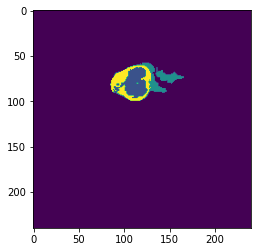

In [59]:
plt.imshow(cv2.imread('/content/brats 2015/BRATS2015/training/HGG/brats_2013_pat0001_1/slices2/truth/z/50.png', 0))

In [0]:
imgd, imgh = load('/content/brats 2015/BRATS2015/training/HGG/brats_2013_pat0001_1/VSD.Brain_3more.XX.O.OT.54517.mha')

In [25]:
imgd.max()

4

In [0]:
import time
import matplotlib.pyplot as plt
%matplotlib inline
def show_a_prediction():
    
    #dataset_location = r'/content/gdrive/My Drive/brats 2015/BRATS2015/'
    dataset_location = r'/content/brats 2015/BRATS2015/'
    print(dataset_location)
    patient_folders = sorted(glob.glob(dataset_location + r'training/HGG/**/'))
    print(patient_folders)
    NUM_TRAIN = len(patient_folders)
    
    batch_size = BATCH_SIZE_TRAIN
    batch_X = []
    batch_y = []
    for folder in patient_folders:
        flair_imgs = folder + 'slices2/flair/z'
        truth_imgs = folder + 'slices2/truth/z'
        truth_shapes = []
        for i, (flair_slice_img, truth_slice_img) in enumerate(zip(glob.glob(flair_imgs + '/*.png'), glob.glob(truth_imgs + '/*.png'))):
            if i < 50: continue
            if i == 155: break
            #print(f'reading {flair_slice_img}, {truth_slice_img}')
            flair_img = cv2.imread(flair_slice_img, 0) / 255
            flair_img = np.expand_dims(np.expand_dims(flair_img, axis=-1),axis=0)
            #batch_X.append(flair_img)

            truth_img = cv2.imread(truth_slice_img, 0)
            truth_img = np.expand_dims(truth_img, axis=-1)
            truth_shapes.append(truth_img.shape)
            #batch_y.append(keras.utils.to_categorical(truth_img, num_classes=5))

            # if len(batch_X) == batch_size:
            #     batch_X = np.array(batch_X)
            #     #print(batch_y)
            #     #print(set(truth_shapes))
            #     batch_y = np.array(batch_y)
            #     #print(batch_y.shape)
            #     #print('giving batch')
            #     yield batch_X, batch_y
            #     batch_X = []
            #     batch_y = []
            underlying = flair_img[0, :, :, 0]
            fig = plt.figure(figsize=(10,5))
            ax = fig.add_subplot(121)
            ax.imshow(underlying, cmap='gray')
            prediction_classes = model.predict(flair_img)
            prediction = np.argmax(prediction_classes, axis=-1, out=None)[0] * (255/4)
            print(prediction.min())
            print(prediction.max())
            ax.imshow(prediction, alpha=0.9)
            ax = fig.add_subplot(122)
            ax.imshow(underlying, cmap='gray')
            ax.imshow((truth_img[:,:,0].T)*(255/4), alpha=0.9)
            plt.show()
            time.sleep(1)

/content/brats 2015/BRATS2015/
['/content/brats 2015/BRATS2015/training/HGG/brats_2013_pat0001_1/', '/content/brats 2015/BRATS2015/training/HGG/brats_2013_pat0002_1/', '/content/brats 2015/BRATS2015/training/HGG/brats_2013_pat0003_1/', '/content/brats 2015/BRATS2015/training/HGG/brats_2013_pat0004_1/', '/content/brats 2015/BRATS2015/training/HGG/brats_2013_pat0005_1/', '/content/brats 2015/BRATS2015/training/HGG/brats_2013_pat0006_1/', '/content/brats 2015/BRATS2015/training/HGG/brats_2013_pat0007_1/', '/content/brats 2015/BRATS2015/training/HGG/brats_2013_pat0008_1/', '/content/brats 2015/BRATS2015/training/HGG/brats_2013_pat0009_1/', '/content/brats 2015/BRATS2015/training/HGG/brats_2013_pat0010_1/', '/content/brats 2015/BRATS2015/training/HGG/brats_2013_pat0011_1/', '/content/brats 2015/BRATS2015/training/HGG/brats_2013_pat0012_1/', '/content/brats 2015/BRATS2015/training/HGG/brats_2013_pat0013_1/', '/content/brats 2015/BRATS2015/training/HGG/brats_2013_pat0014_1/', '/content/brats 

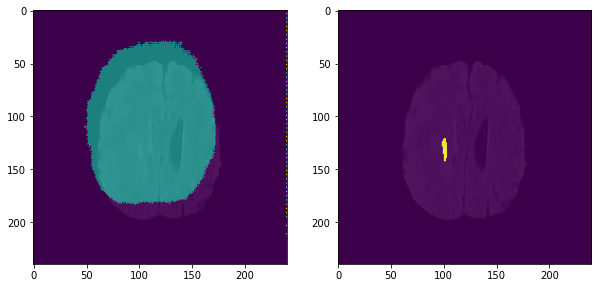

0.0
255.0


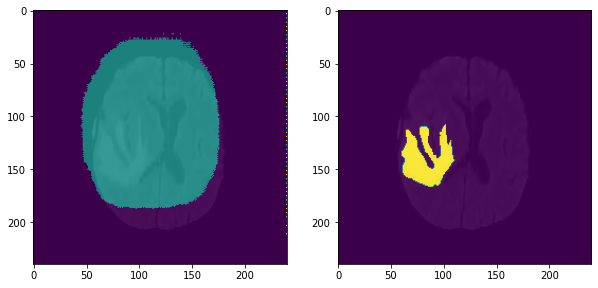

0.0
255.0


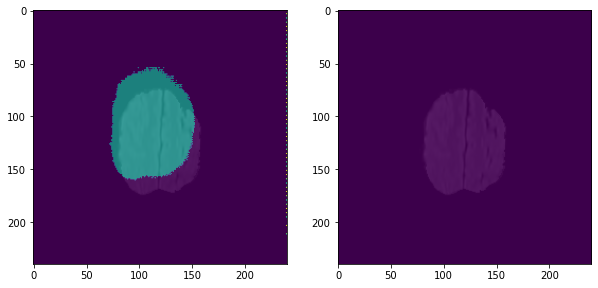

0.0
255.0


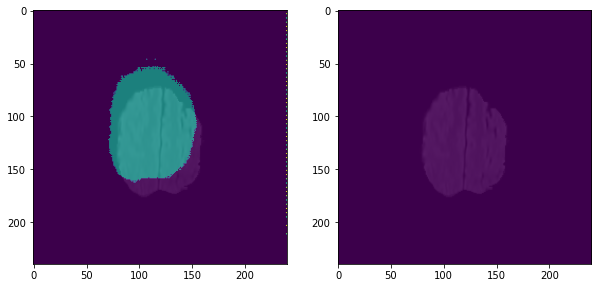

0.0
255.0


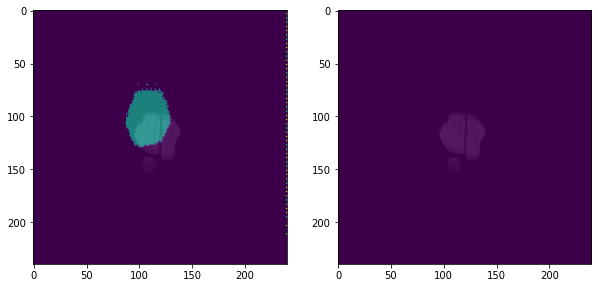

0.0
255.0


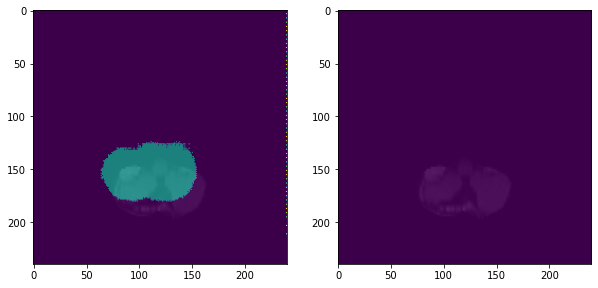

0.0
255.0


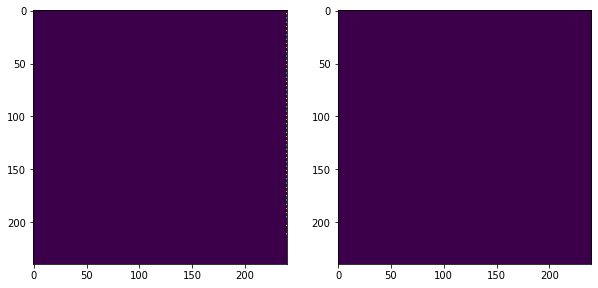

0.0
255.0


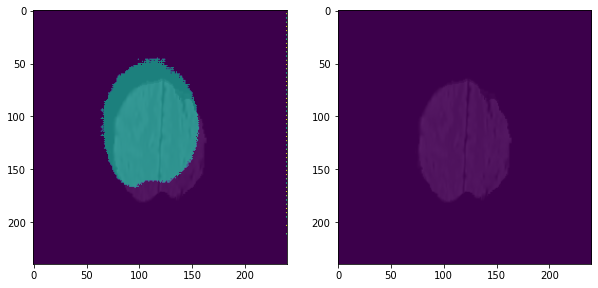

0.0
255.0


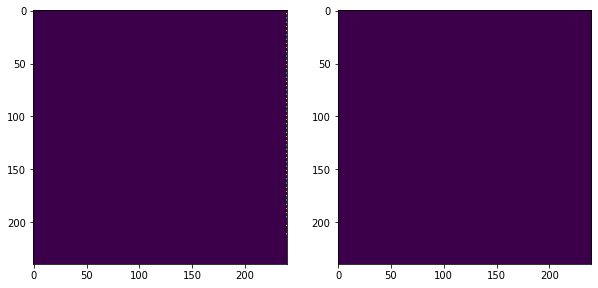

0.0
255.0


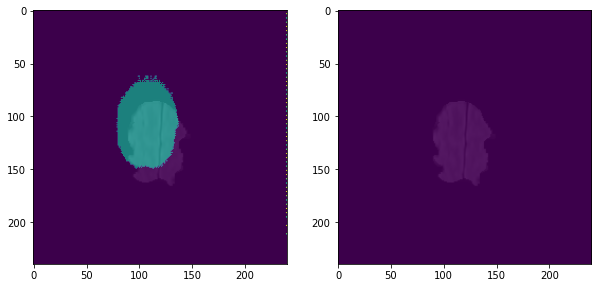

0.0
255.0


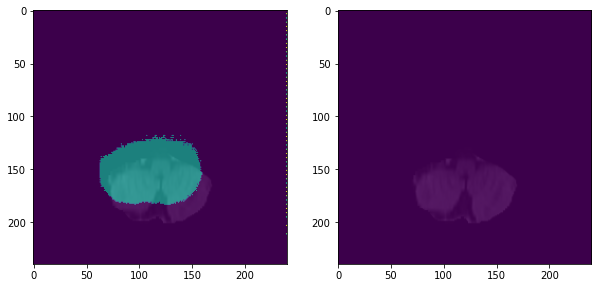

0.0
255.0


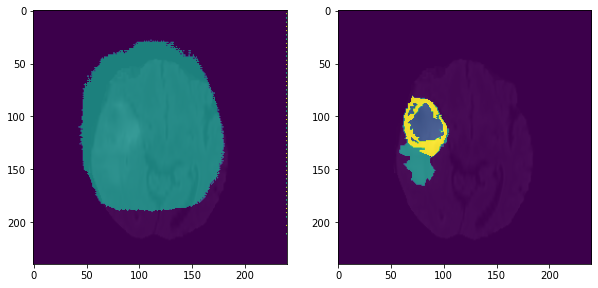

0.0
255.0


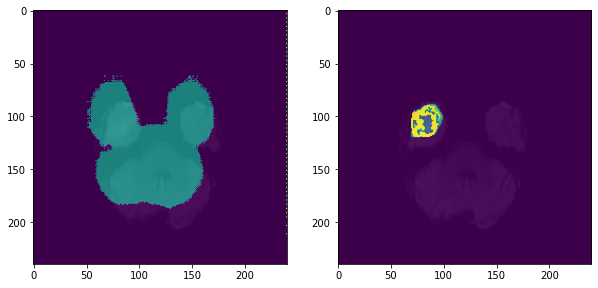

0.0
255.0


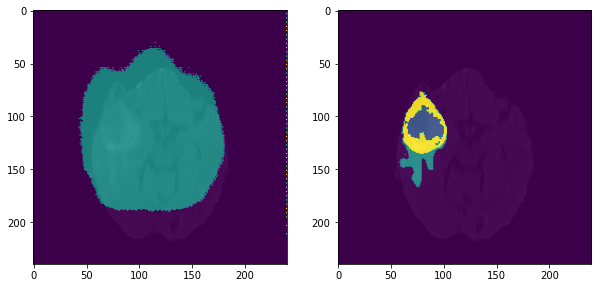

0.0
255.0


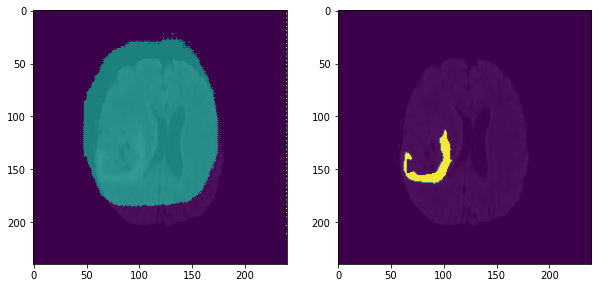

0.0
255.0


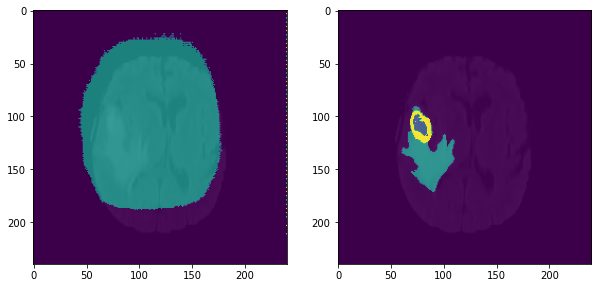

0.0
255.0


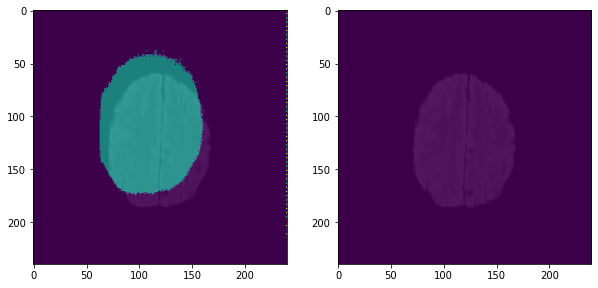

0.0
255.0


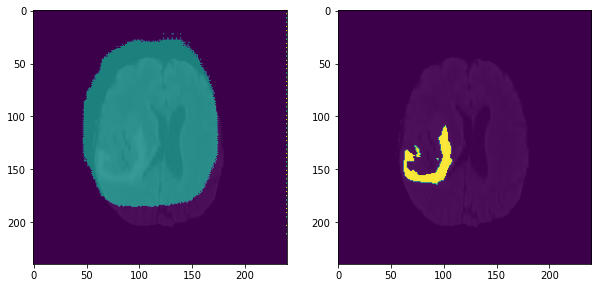

0.0
255.0


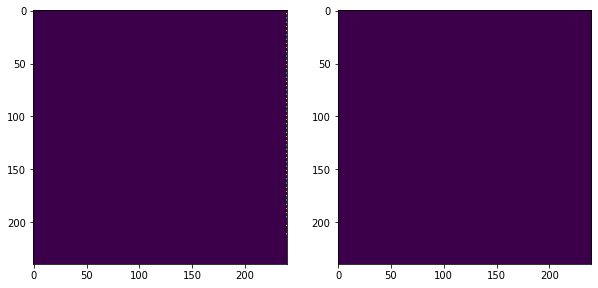

0.0
255.0


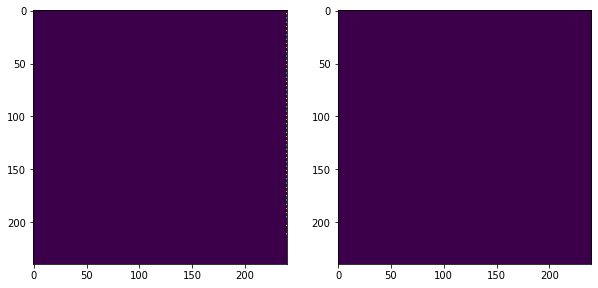

0.0
255.0


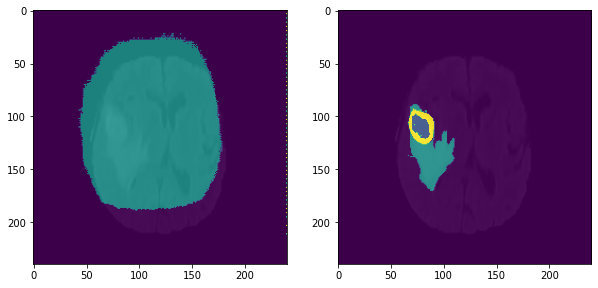

0.0
255.0


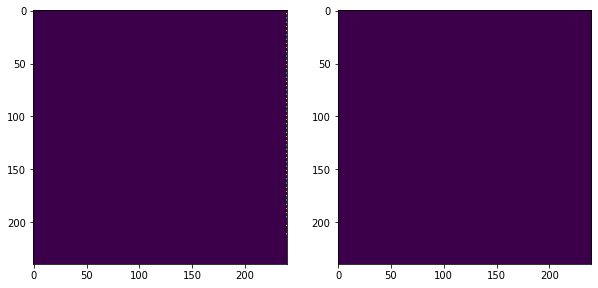

0.0
255.0


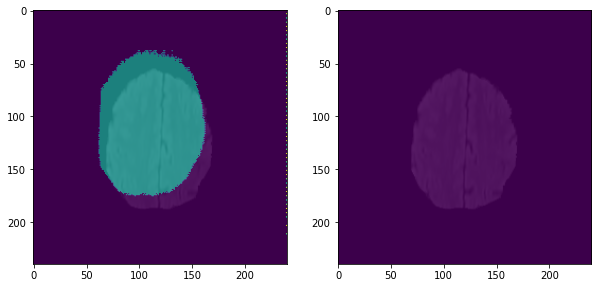

0.0
255.0


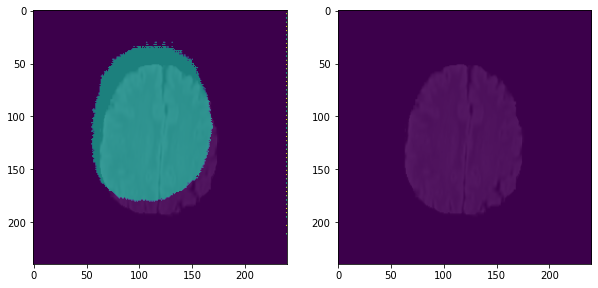

0.0
255.0


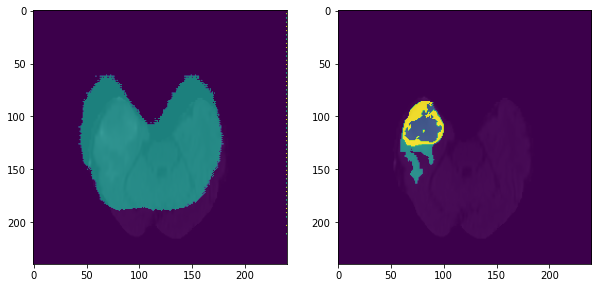

0.0
255.0


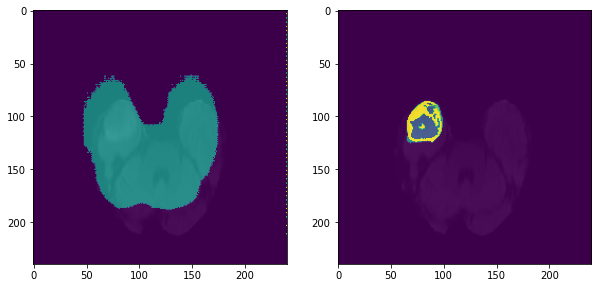

0.0
255.0


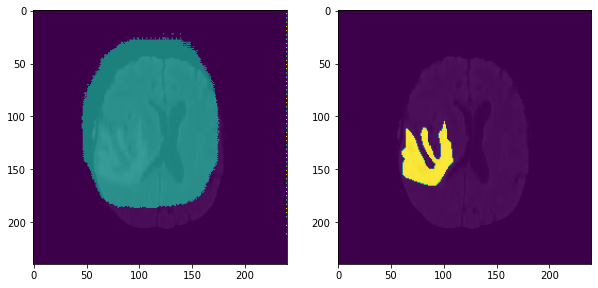

0.0
255.0


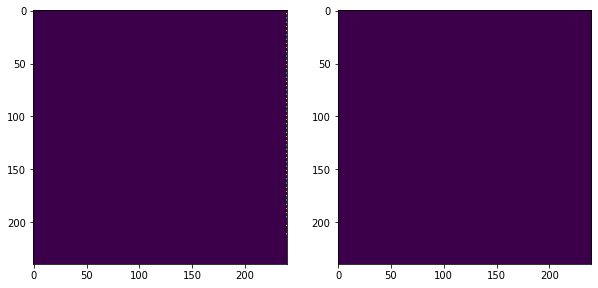

0.0
255.0


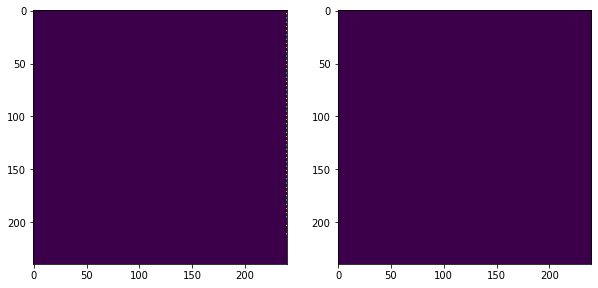

KeyboardInterrupt: ignored

In [62]:
show_a_prediction()

In [0]:
!ls 'brats 2015/BRATS2015/training/HGG/brats_2013_pat0001_1/slices/flair/z'

0.png	 124.png  149.png  173.png  198.png  221.png  2.png   54.png  79.png
100.png  125.png  14.png   174.png  199.png  222.png  30.png  55.png  7.png
101.png  126.png  150.png  175.png  19.png   223.png  31.png  56.png  80.png
102.png  127.png  151.png  176.png  1.png    224.png  32.png  57.png  81.png
103.png  128.png  152.png  177.png  200.png  225.png  33.png  58.png  82.png
104.png  129.png  153.png  178.png  201.png  226.png  34.png  59.png  83.png
105.png  12.png   154.png  179.png  202.png  227.png  35.png  5.png   84.png
106.png  130.png  155.png  17.png   203.png  228.png  36.png  60.png  85.png
107.png  131.png  156.png  180.png  204.png  229.png  37.png  61.png  86.png
108.png  132.png  157.png  181.png  205.png  22.png   38.png  62.png  87.png
109.png  133.png  158.png  182.png  206.png  230.png  39.png  63.png  88.png
10.png	 134.png  159.png  183.png  207.png  231.png  3.png   64.png  89.png
110.png  135.png  15.png   184.png  208.png  232.png  40.png  65.png  8.png
111.

In [0]:
!cd './brats 2015'

In [0]:
os.chdir('./brats 2015')

In [0]:
!ls

In [0]:
ls BRATS2015/training/HGG/brats/brats_2013_pat0001_1